In [571]:
from IPython.display import Markdown as md
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.animation import FuncAnimation
import os
from scipy.io import loadmat
import math
import pandas as pd
from scipy.signal import butter,filtfilt, lfilter
from scipy import signal
from scipy.ndimage import convolve1d
from scipy.interpolate import interp1d

## Carico la matrice

In [572]:
percorso="/home/davide/Documents/FESI"
patient = '211_01_R_joints'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/Pazienti/"+patient+".mat")
data_filter = data[list(data.keys())[-1]]


Do' un'occhiata ai grafici

In [573]:
print(data_filter)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


Ci sono parecchi nan, vado a levare solo quelli agli estremi così dopo posso completare i valori mancanti all'interno dei grafici

In [574]:
#funzione per levare nan agli estremi
def nanRem(arr):
    start, end = 0, len(arr)-1
    while(np.isnan(arr[start])):
        start+=1
    while(np.isnan(arr[end])):
        end-=1
    newarray = np.array(arr[start:end])
    return newarray
        

In [575]:
anca_x = nanRem(data_filter[:,0])
anca_y = nanRem(data_filter[:,1])
ginocchio_x = nanRem(data_filter[:,2])
ginocchio_y = nanRem(data_filter[:,3])
caviglia_x = nanRem(data_filter[:,4])
caviglia_y = nanRem(data_filter[:,5])
piede_x = nanRem(data_filter[:,6])
piede_y = nanRem(data_filter[:,7])

segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]
#fare la trasposta

Dopo aver diviso in liste le coordinate x e y di ogni punto e dopo aver levato i nan vado a plottare

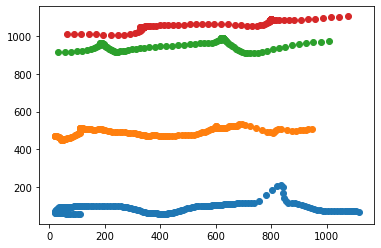

In [576]:
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

Oltre al fatto che il grafico è rovesciato, ci sono anche delle interferenze.

# Inverto l'asse y:

Semplicemente prendo ogni valore degli array contenenti le y e lo sottraggo al valore massimo globale 

In [577]:
def inverti_y(segnali):
    massimo = max(np.nanmax(segnali[1]), np.nanmax(segnali[3]), np.nanmax(segnali[5]), np.nanmax(segnali[7]))
    for i in (1,3,5,7):
        segnali[i]=massimo-segnali[i]    

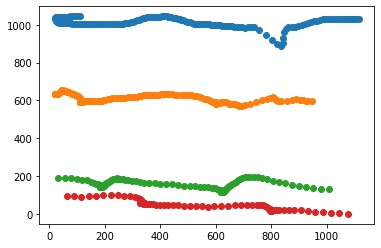

In [578]:
inverti_y(segnali)
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Inverto l'asse x:

Se la gamba che sto analizzando è la destra, è comodo invertire l'asse x per evitare che tutto sia specchiato:

In [579]:
def inverti_x(file, segnali):
    if "R" in file or "dx" in file:
        massimo = max(np.nanmax(segnali[0]), np.nanmax(segnali[2]), np.nanmax(segnali[4]), np.nanmax(segnali[6]))
        for i in (0,2,4,6):
            segnali[i]=massimo-segnali[i]   

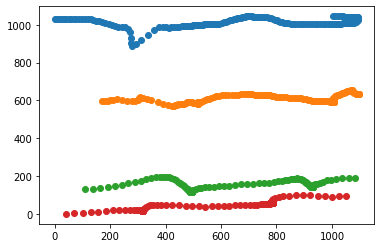

In [580]:
inverti_x(patient, segnali)
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Correggo le interferenze con dei filtri

Prendo come esempio i valori x dell'anca per far vedere come operano i filtri plottando i risultati intermedi.

## Interpolazione

Interpolo i valori mancanti sostituendo i nan.

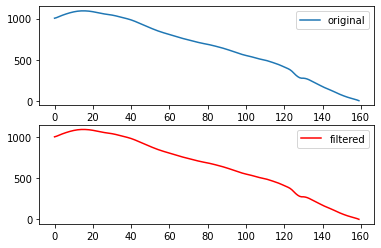

In [581]:
res=pd.Series(segnali[0]).interpolate(method='polynomial', order=2)

plt.figure()
plt.subplot(211)
plt.plot(segnali[0])
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(res, 'r')
plt.legend(['filtered'])
plt.show()

## Passa-basso

Applico un filtro passa-basso con frequenza 12Hz poichè il corpo umano non riesce a muoversi a questa frequenza e quindi i dati rilevati saranno sicuramente disturbi.

Faccio la trasformata di Fourier del mio segnale:

(-1.0, 100000.0)

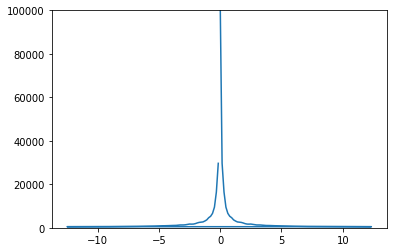

In [582]:
fs = 25
fft_f = np.fft.fft(res)
n = len(fft_f)
freq = np.fft.fftfreq(n, 1/fs)

plt.plot(freq,np.abs(fft_f))  
plt.ylim([-1,100000])

Applico il filtro levando le frequenze maggiori di 12Hz

(-1.0, 100000.0)

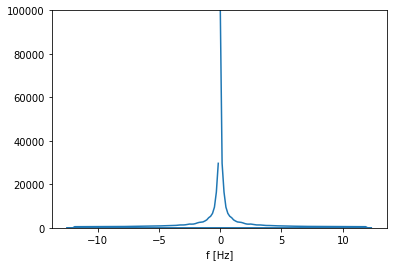

In [583]:
idx = np.argwhere(np.abs(freq)>12)
fft_cut=np.copy(fft_f)
fft_cut[idx]=0

plt.plot(freq,np.abs(fft_cut) )
plt.xlabel('f [Hz]')
plt.ylim([-1,100000])

Applico una trasformata di Furier inversa e plotto il segnale risultante

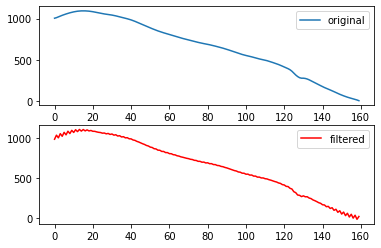

In [584]:
f_cut=np.fft.ifft(fft_cut)

plt.figure()
plt.subplot(211)
plt.plot(res)
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(np.real(f_cut),'r')
plt.legend(['filtered'])
plt.show()

## Mediano

Applico infine un filtro mediano per levare eventuali spike localizzati dovuti ad errori nella raccolta dei movimenti

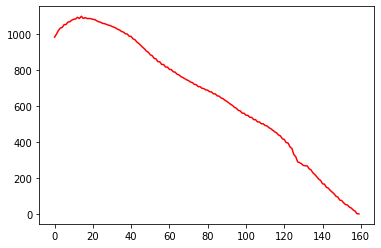

In [585]:
filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 
plt.plot(filt_med, 'r')

## Gaussiano

Ora applico un filtro gaussiano.

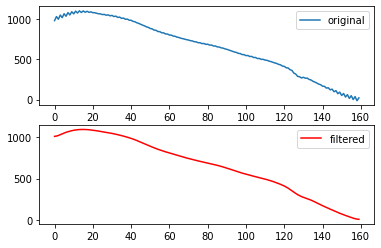

In [586]:
windowg = signal.windows.gaussian(9, std=3) #cambiare valori della gaussian
windowg /= sum(windowg)
filt = convolve1d(filt_med, windowg)

plt.figure()
plt.subplot(211)
plt.plot(np.real(f_cut))
plt.legend(['original'])
plt.subplot(212)
plt.plot(filt, 'r')
plt.legend(['filtered'])
plt.show()

## Filtri applicati sugli altri segnali

Ora faccio le stesse operazioni su tutti gli altri segnali (anca_y , ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x e piede_y)

In [587]:
def pulizia(segnali):    
    for i in range(8):

        segnali[i]=pd.Series(segnali[i]).interpolate(method='polynomial', order=2)

        fs = 25
        fft_f = np.fft.fft(segnali[i])
        n = len(fft_f)
        freq = np.fft.fftfreq(n, 1/fs)

        idx = np.argwhere(np.abs(freq)>12)
        fft_cut=np.copy(fft_f)
        fft_cut[idx]=0

        f_cut=np.fft.ifft(fft_cut)

        filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 

        windowg = signal.windows.gaussian(9, std=3)
        windowg /= sum(windowg)
        segnali[i] = convolve1d(filt_med, windowg)

In [588]:
pulizia(segnali)

## Plot

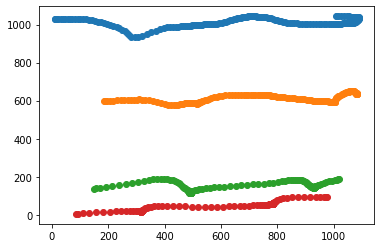

In [589]:
for i in (0, 2, 4, 6):
    segnali[i]=segnali[i][0:segnali[i+1].size]
    segnali[i+1]=segnali[i+1][0:segnali[i].size]
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Gif

Vado a creare una gif per evidenziare i movimenti della gamba nel tempo.

Prima di tutto importo le libreire:

In [590]:
import matplotlib.animation as animation
from IPython import display

Ora inizializzo il grafico:

In [591]:
min_x=min(min(segnali[0]),min(segnali[2]),min(segnali[4]),min(segnali[6]))
max_x=max(max(segnali[0]),max(segnali[2]),max(segnali[4]),max(segnali[6]))
min_y=min(min(segnali[1]),min(segnali[3]),min(segnali[5]),min(segnali[7]))
max_y=max(max(segnali[1]),max(segnali[3]),max(segnali[5]),max(segnali[7]))

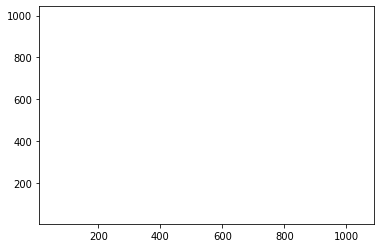

In [620]:
fig = plt.figure()
axis = plt.axes(xlim = (min_x, max_x),
                ylim = (min_y, max_y))

line, = axis.plot([], [], lw = 2)

In [593]:
def init():
    line.set_data([], [])
    return line,

Creo la funzione che andrà a restituire i singoli punti:

In [594]:
# function takes frame as an input
def animate(frame):
    xdata, ydata = [], []
    for i in (0,2,4,6):
        if(frame<len(segnali[i])):
            x=segnali[i][frame]
            xdata.append(x)
           
        if(frame<len(segnali[i+1])):
            y=segnali[i+1][frame]
            ydata.append(y)
        
    line.set_data(xdata, ydata)
    return [line]

Ora creo la Gif e la salvo:

In [595]:
%matplotlib notebook

frames=len(segnali[0])#da controllare


anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames=frames,
                            interval = 20,
                            blit = True)
plt.show()

In [596]:
anim.save('gamba.mp4', writer = 'ffmpeg', fps = 30)


%matplotlib inline

# Tempo di appoggio

Andiamo ad analizzare la distanza tra i passi:

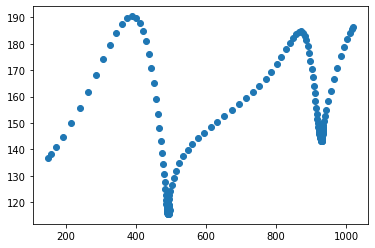

In [597]:
plt.plot_date(segnali[4], segnali[5],xdate=False)
plt.show()

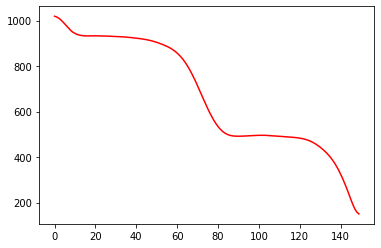

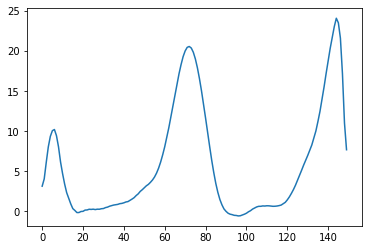

In [598]:
from scipy.signal import find_peaks
#!pip install sympy
from sympy import *

plt.plot(segnali[4], "r")
plt.show()

der=np.gradient(-segnali[4])
plt.plot(der)
plt.show()

la distanza tra i picchi è il tempo che è stato fermo il piede, il numero di picchi è il numero di passi.

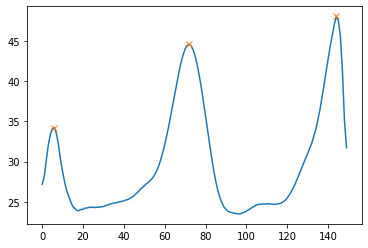

In [599]:
filt_cut = der
filt_cut += np.max(der)
peaks, _ = find_peaks(filt_cut, np.mean(der))
plt.plot(filt_cut)
plt.plot(peaks, filt_cut[peaks], "x")
plt.show()

Questi sono i picchi:

In [600]:
print(peaks)

[  6  72 144]


La distanza media tra uno e l'altro (ovvero il tempo in cui il piede sta a terra) è:

In [601]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
print(dist)

[66, 72]


In [602]:
n=int(np.mean(dist))
md("In media il soggetto tiene appoggiato il piede a terra per {} frame che corrispondono a {} secondi".format(n, n/25))

In media il soggetto tiene appoggiato il piede a terra per 69 frame che corrispondono a 2.76 secondi

Andiamo a vedere quanto tempo rimane a terra il piede di un soggetto sano.

Carico i dati:

In [603]:
sano = 'S004_sx'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/"+sano+".mat")
data_filter = data[list(data.keys())[-1]]

In [604]:
segnaliSano=[]
for i in range(8):
    segnaliSano.append(nanRem(data_filter[:,i]))

Plotto il movimento della caviglia:

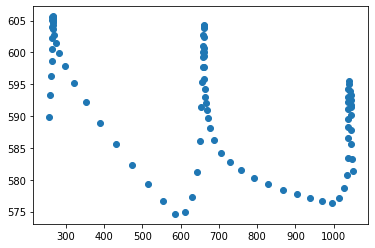

In [605]:
plt.plot_date(segnaliSano[4], segnaliSano[5],xdate=False)
plt.show()

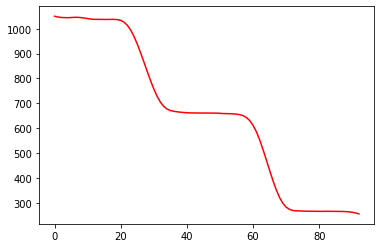

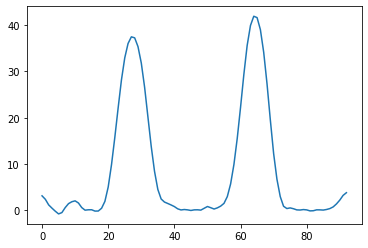

In [606]:
plt.plot(segnaliSano[4], "r")
plt.show()

der=np.gradient(-segnaliSano[4])
plt.plot(der)
plt.show()

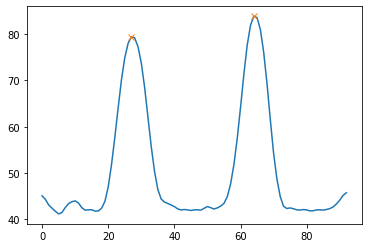

In [607]:
filt_cut = der
filt_cut += np.max(der)
peaks, _ = find_peaks(filt_cut, np.mean(der))
plt.plot(filt_cut)
plt.plot(peaks, filt_cut[peaks], "x")
plt.show()

In [608]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
n=int(np.mean(dist))
md("In media il soggetto tiene appoggiato il piede a terra per {} frame che corrispondono a {} secondi".format(n, n/25))

In media il soggetto tiene appoggiato il piede a terra per 37 frame che corrispondono a 1.48 secondi

Sembrerebbe che i pazienti camminando tendato a lasciare il piede per più tempo poggiato a terra rispetto ai soggetti sani.

Andiamo a verificare l'ipotesi prendendo la media dei tempi dei soggetti sani e confrontatndola con quella dei pazienti.

Prima esaminiamo i pazienti:

In [609]:
def tempoTerra(targetPattern):
    mean=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        data = loadmat(file)
        data_filter = data[list(data.keys())[-1]]
        segnali=[]
        for i in range(8):
            #rimuovo i nan
            segnali.append(nanRem(data_filter[:,i]))
        #invero l'asse y
        inverti_y(segnali)
        #invero l'asse x per i file contenenti dati seulle gambe di destra
        inverti_x(file, segnali)
        #pulisco i segnali
        pulizia(segnali)
        #calcolo la derivata
        der=np.gradient(-segnali[4])
        filt_cut = der
        filt_cut += np.max(der)
        #trovo i picchi
        peaks, _ = find_peaks(filt_cut, np.mean(der))
        '''plt.plot(filt_cut)
        plt.plot(peaks, filt_cut[peaks], "x")
        plt.show()'''
        dist=[]
        #calcolo la distanza tra i picchi (frame in cui il piede sta a terra)
        #se nella registrazione c'è solo un picco non ha senso calcolare la distanza
        if(len(peaks)!=1):
            for i in range(len(peaks)-1):
                dist.append(abs(peaks[i]-peaks[i+1]))
            mean.append(int(np.mean(dist)))            
    return(np.mean(mean)/25)

In [610]:
tempo=tempoTerra(percorso+"/Pazienti/*.mat")
md("In media i pazienti tengono appoggiato il piede a terra per {} secondi".format(tempo))

In media i pazienti tengono appoggiato il piede a terra per 1.8553846153846154 secondi

In [611]:
tempo=tempoTerra(percorso+"/*.mat")
md("In media i soggetti sani tengono appoggiato il piede a terra per {} secondi".format(tempo))

In media i soggetti sani tengono appoggiato il piede a terra per 1.3288888888888888 secondi

# Altezza dei passi

Andiamo ora a confrontare l'altezza media dei passi dei soggetti sani e quella dei pazienti.

Plotto i valori della caviglia sull'asse y

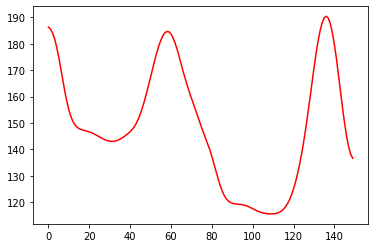

In [612]:
plt.plot(segnali[5], "r")
plt.show()

Ora trovo i picchi e le valli. Il valore dei picchi è ottenuto sottraendo all'altezza del picco il valore più basso delle y, in questo modo il picco indica l'altezza del passo.

Picchi:

In [613]:
def peaksFinder(y):
    peaksValue=[]
    filt_cut = y
    filt_cut += np.max(np.abs(y))
    peaks, _ = find_peaks(filt_cut, np.mean(np.abs(y)))
    plt.plot(filt_cut)
    plt.plot(peaks, filt_cut[peaks], "o")
    plt.show()
    for peak in peaks:
        peaksValue.append(y[peak]-min(y))
    return peaksValue

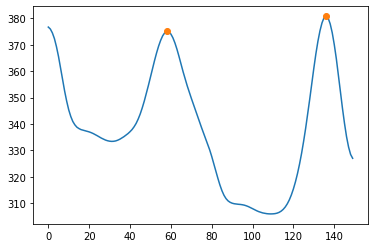

[69.10940865728679, 74.86546074488842]


In [614]:
peaks=peaksFinder(segnali[5])
print(peaks)

Valli:

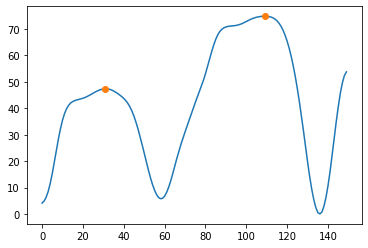

[47.39418243048857, 74.86546074488842]


In [615]:
valleys=peaksFinder(-segnali[5])
print(valleys)

Ora calcolo la distanza tra il valore medio dei picchi e il valore medio delle valli:

In [616]:
altezzaMedia=np.mean(peaks)-np.mean(valleys)
print(altezzaMedia)

10.857613113399111


Adesso faccio lo stesso procedimento con tutti i pazienti e tutti i soggetti sani:

In [617]:
def altezzaPassi(targetPattern):
    altezze=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        data = loadmat(file)
        data_filter = data[list(data.keys())[-1]]
        valori=[]
        for i in range(8):
            #rimuovo i nan
            valori.append(nanRem(data_filter[:,i]))
        #invero l'asse y
        inverti_y(valori)
        #invero l'asse x per i file contenenti dati seulle gambe di destra
        inverti_x(file, valori)
        #pulisco i segnali
        pulizia(valori)
        peaks=peaksFinder(valori[5])
        print(peaks)
        valleys=peaksFinder(-valori[5])
        print(valleys)
        altezze.append(np.mean(peaks)-np.mean(valleys))
    return np.mean(altezze)

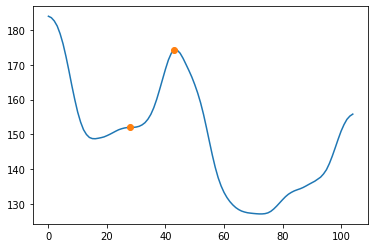

[24.926593111469856, 47.20765475674966]


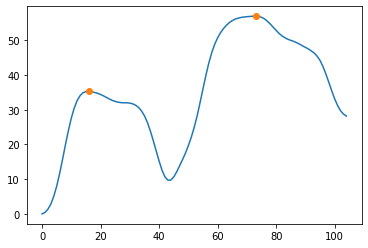

[35.273639999031445, 56.92225028891227]


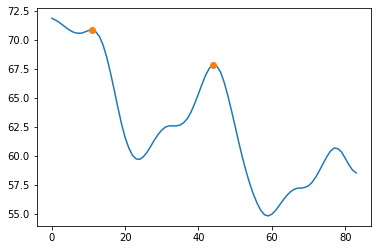

[16.066923861139784, 13.06548581838895]


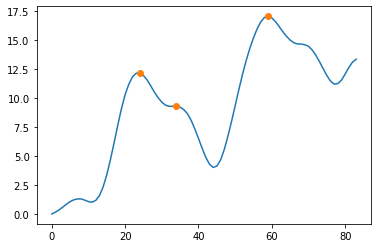

[12.193490201164359, 9.300119293739286, 17.08074582952851]


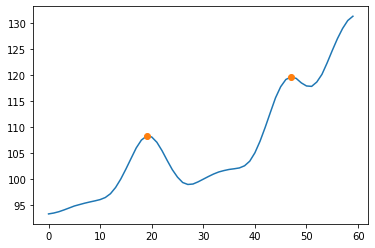

[14.952331494714443, 26.33104574952877]


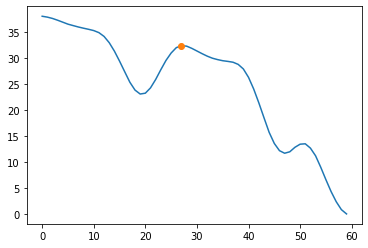

[32.334077115991036]


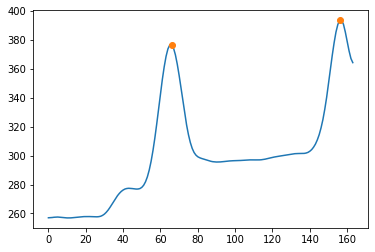

[119.85767697444066, 136.7948856179417]


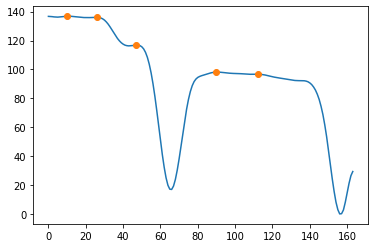

[136.7948856179417, 136.0370174566582, 116.82565872098672, 98.11665094938093, 96.67146467935203]


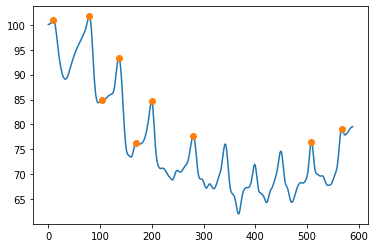

[38.79014523603152, 39.63259669878762, 22.901080816678075, 31.260230139835997, 14.286354933426495, 22.650015872469908, 15.631182968799038, 14.504813073241763, 17.08061127201985]


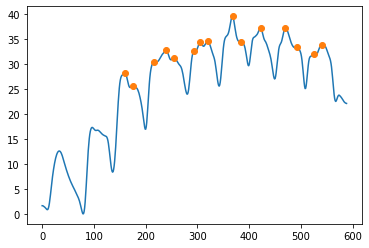

[28.22731838716861, 25.645104234155312, 30.517180272894308, 32.819052063469044, 31.241175919920764, 32.63049155646368, 34.449519236696375, 34.57385121576971, 39.63259669878762, 34.37546345301439, 37.34655385345893, 37.311408094001564, 33.43822952502248, 32.0493589785558, 33.90220854959087]


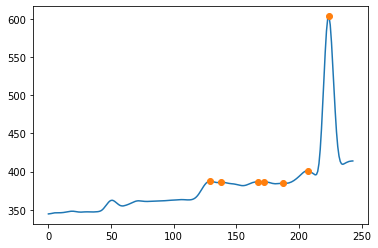

[42.880292469183644, 41.47252633225361, 42.04477641099527, 42.03808583240112, 40.146959442314994, 56.57086869077352, 259.23127909083166]


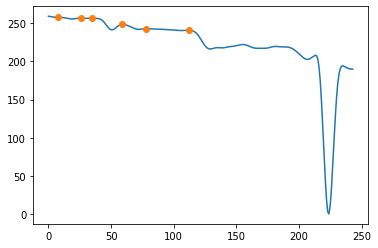

[257.7771825289941, 256.88153271340076, 256.69199371658624, 248.7890957433055, 242.88426665418626, 240.85153613472028]


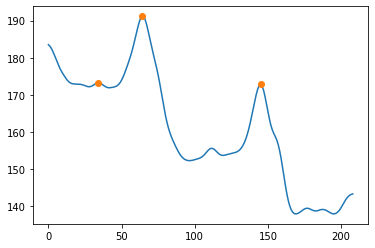

[35.264231164879135, 53.21176080108063, 34.85773383064995]


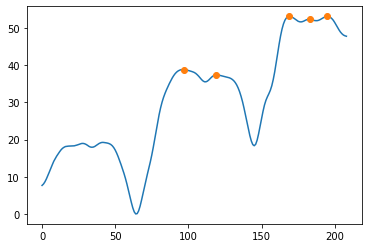

[38.86603547314911, 37.46103537031277, 53.20975504633142, 52.403656462681425, 53.21176080108063]


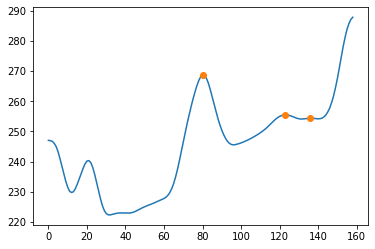

[46.43325259688925, 33.19297065658975, 32.104162499791755]


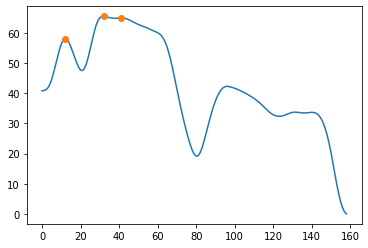

[58.149840843868446, 65.5758858939476, 64.95720593761541]


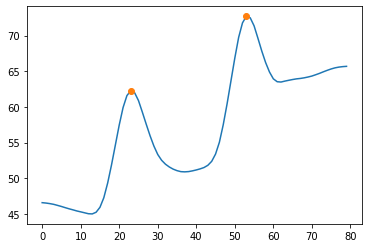

[17.25888604728965, 27.69192418071976]


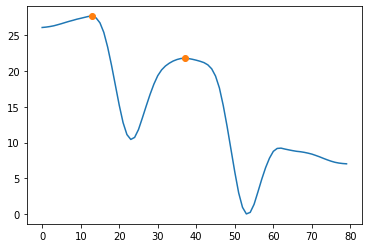

[27.69192418071976, 21.799159909848036]


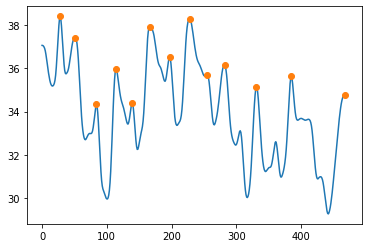

[9.124552176152445, 8.124810453623919, 5.055263010248989, 6.704009604553544, 5.121641503466865, 8.632563752372288, 7.248279533904569, 9.007578483773141, 6.429624016069116, 6.867311563972475, 5.874606485838466, 6.347722924245058, 5.479390340705823]


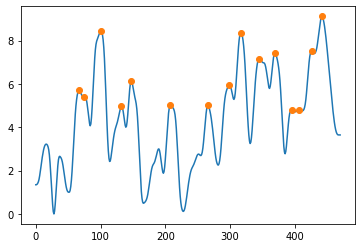

[5.698479798900898, 5.4160634423484595, 8.432483361970114, 4.971086893532025, 6.147375053691789, 5.035118056476946, 5.014523687577295, 5.94781657262827, 8.368889290092156, 7.168743027943847, 7.428240462038815, 4.798973620060465, 4.7982062815396915, 7.507563504044949, 9.124552176152445]


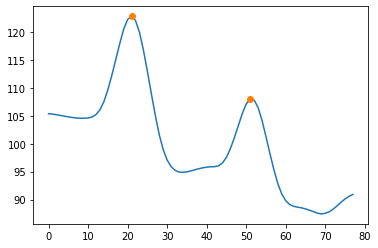

[35.35824825293949, 20.55927206075087]


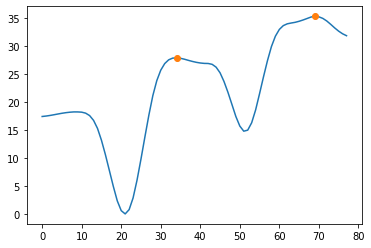

[27.917510400728403, 35.35824825293949]


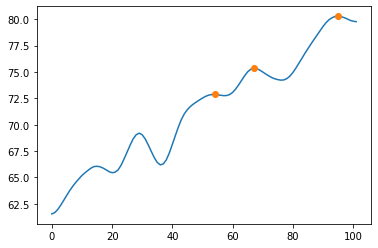

[11.334002748772505, 13.81111239279032, 18.74324604245595]


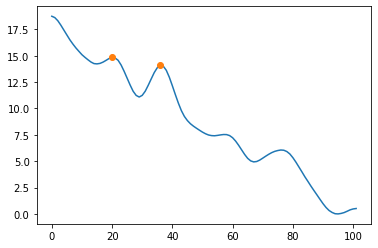

[14.836739978676931, 14.09332262897182]


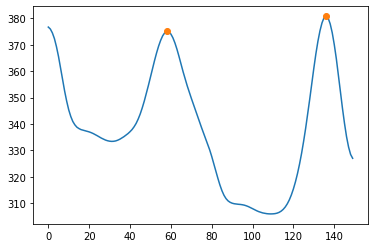

[69.10940865728679, 74.86546074488842]


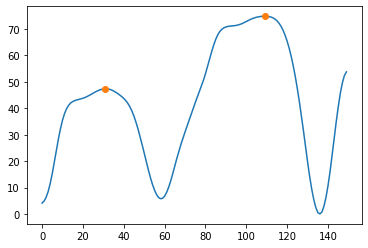

[47.39418243048857, 74.86546074488842]


In media i pazienti alzano il piede di -16.877226668037423

In [618]:
altezza=altezzaPassi(percorso+"/Pazienti/*.mat")
md("In media i pazienti alzano il piede di {}".format(altezza))

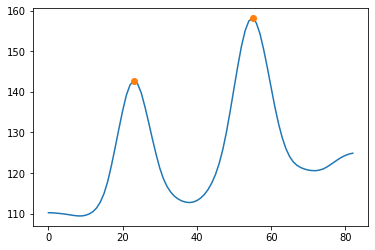

[33.23125193248731, 48.63536510160168]


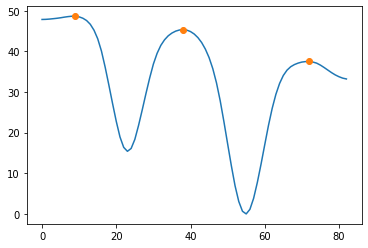

[48.63536510160168, 45.350889054451585, 37.51142000340003]


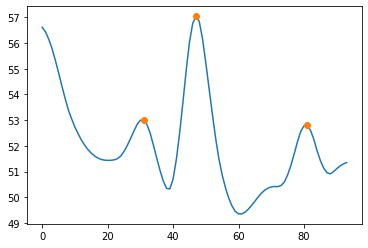

[3.651784035706548, 7.691383456662514, 3.4424227134425323]


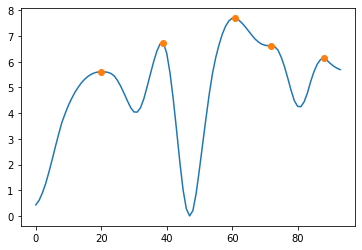

[5.607719123985774, 6.719547840395869, 7.691383456662514, 6.630254235617386, 6.134644125601227]


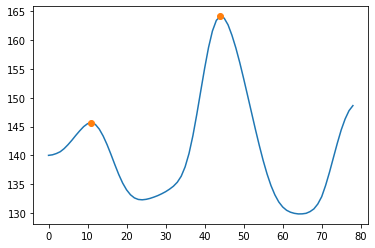

[15.8086224515163, 34.28504423264795]


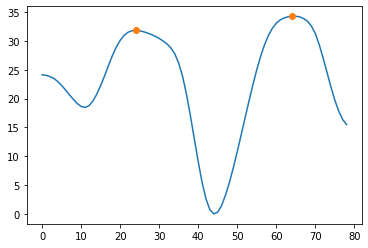

[31.837189593529388, 34.28504423264795]


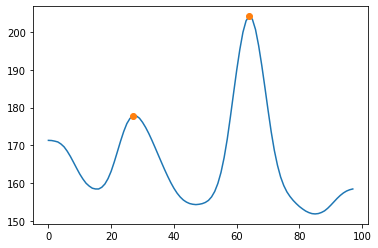

[25.929663000779954, 52.211415842386145]


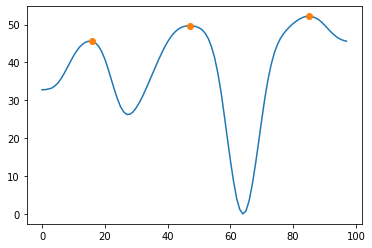

[45.62726364094871, 49.751800310757915, 52.211415842386145]


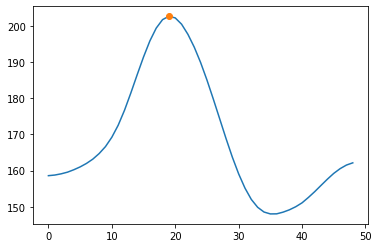

[54.67340276157617]


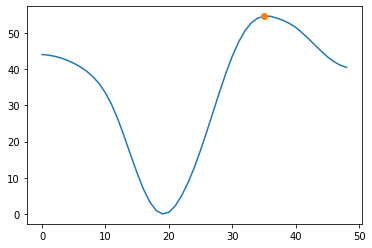

[54.67340276157617]


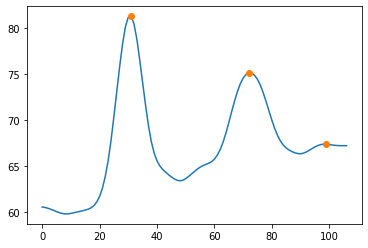

[21.506649273067126, 15.356534244237409, 7.594185261659675]


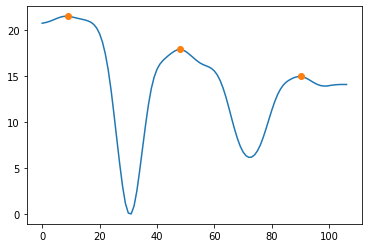

[21.506649273067126, 17.904648933877013, 14.966172254364864]


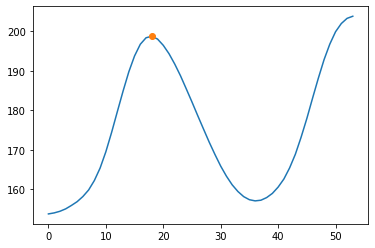

[44.95463790995464]


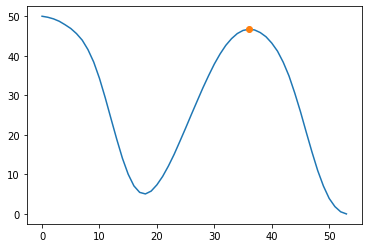

[46.7132911944351]


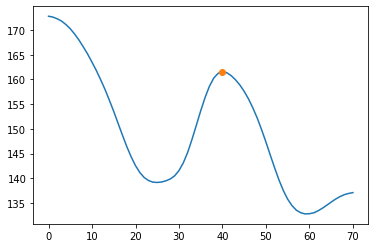

[28.78342919005894]


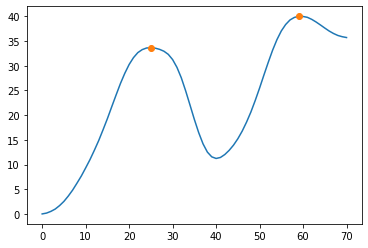

[33.637292617978005, 40.00701436775151]


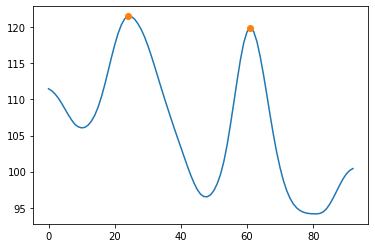

[27.365953179821204, 25.762694599578822]


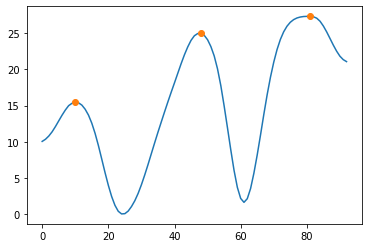

[15.454043552004848, 24.985444412738786, 27.365953179821204]


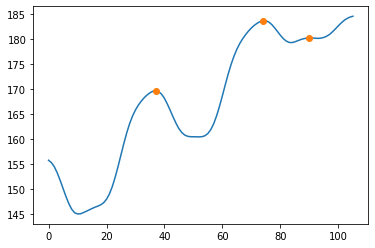

[24.66786426598398, 38.70392627215455, 35.249268867001746]


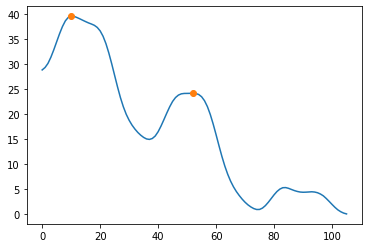

[39.58803781794319, 24.160949275565514]


In media i soggetti sani alzano il piede di -3.081037502300678

In [619]:
altezza=altezzaPassi(percorso+"/*.mat")
md("In media i soggetti sani alzano il piede di {}".format(altezza))